In [42]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy.lib.function_base import cov
n = 10000
m = 3*n
eps = 0.1
data_dim = 100
mu = 5
mu_out = 0
par_mu = np.full(data_dim, mu)
par_sd = np.eye(data_dim)
out_mu = np.full(data_dim, mu_out)
out_sd = np.eye(data_dim)
par_reg1 = 0.0005
par_reg2 = 0.0005
exper_iter = 1
optim_iter = 100
L = 1
learn_par = 0.05
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20

def mean_outer_product(z1, z2): #(n, d)*(n, d)  vector_wise_dot->  (n, d, d)  mean-> (d, d)
    outer_product = z2[:, np.newaxis, :]*z1[:, :, np.newaxis]
    return np.mean(outer_product, axis = 0)

In [43]:
#分散を単位行列で固定
res = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    data = np.random.multivariate_normal(mean = par_mu, cov = par_sd, size = int(n*(1-eps)))
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_sd, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination], axis = 0)
    np.random.shuffle(data)
    alpha_hist = []
    alpha = [np.median(data, axis=0), np.eye(data_dim)]
    z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
    par = np.random.normal(loc = 0, scale = 0.1, size = 2*data_dim)
    bias = np.array(np.mean(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim])))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0)
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
        l = 0
        z_sq = z**2
        data_sq = data**2
        while l<L:
            par_a = par[0:data_dim]; par_b = par[data_dim: 2*data_dim]; bias = par[-1]
            t0_z = z_sq@par_a + z@par_b - bias #shape (m,)
            t0_data = data_sq@par_a + data@par_b - bias # (n,)
           
            #連立方程式の行列を求める Ax = b
            # ここからがMMアルゴリズムの計算
            A1 = -1/10 * (mean_outer_product(z_sq, z_sq) + mean_outer_product(data_sq, data_sq))
            A2 = -1/10 * (mean_outer_product(z_sq, z)    + mean_outer_product(data_sq, data))
            A3 =  1/10 * (z_sq.mean(axis=0)                   +data_sq.mean(axis=0))
            b1 = - ((deriv_sigmoid(t0_z)+t0_z/10)[:, np.newaxis]*z_sq).mean(axis=0) + ((deriv_sigmoid(t0_data) -t0_data/10)[:, np.newaxis]*data_sq).mean(axis=0)

            A4 = -1/10 * (mean_outer_product(z, z_sq) + mean_outer_product(data, data_sq))
            A5 = -1/10 * (mean_outer_product(z, z)    + mean_outer_product(data, data))
            A6 =  1/10 * z.mean(axis=0)                  + 1/10*data.mean(axis=0)
            b2 = -((deriv_sigmoid(t0_z)+t0_z/10)[:,np.newaxis]*z).mean(axis=0) +((deriv_sigmoid(t0_data) -t0_data/10)[:,np.newaxis]*data).mean(axis=0)

            A7 = -1/10 * z_sq.mean(axis=0) + 1/10 * data_sq.mean(axis=0)
            A8 = -1/10 * z.mean(axis=0)    + 1/10 * data.mean(axis=0)
            A9 = np.full(1, -0.2)
            b3 = np.array([np.mean(deriv_sigmoid(t0_z)  -t0_z/10, axis = 0) - np.mean(deriv_sigmoid(t0_data) -t0_data/10, axis=0)])
            
            A_a = np.concatenate([A1, A2, A3[:, np.newaxis]], axis=1)
            A_b = np.concatenate([A4, A5, A6[:, np.newaxis]], axis=1)
            A_bias = np.concatenate([A7, A8, A9], axis=0)
            A = np.concatenate([A_a, A_b, A_bias[np.newaxis, :]], axis=0)
            b = np.concatenate([b1, b2, b3], axis=0)

            par = np.linalg.solve(A, b)
            l +=1
            # ここまで




        alpha_m = alpha[0]
        mgrad = (z-alpha_m)
        sig_ = sigmoid(np.dot(np.stack([z**2, z], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim ])- par[2*data_dim])[:,np.newaxis]
        tmp_alpha = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        alpha[0] = tmp_alpha
        alpha_hist.append(alpha[0])
    res[i] = alpha_hist



1/1


 25%|██▌       | 25/100 [04:04<11:13,  8.99s/it]

In [40]:
def plot_2dim(res):
    mu_result = np.array(res)
    num_graph_row = 2
    exper_iter = mu_result.shape[0]
    optim_iter = mu_result.shape[1]
    plt.figure(figsize=(4*num_graph_row,4*exper_iter))
    half = int(optim_iter/2)
    mean=[]
    for i in (range(exper_iter)):
        # mu
        plt.subplot(exper_iter,num_graph_row, num_graph_row*i +1)
        plt.title("estimaterd mu")
        # plt.ylim(4.75, 5.3)
        # plt.xlim(4.75, 5.3)
        plt.scatter(mu_result[i,:half,0], mu_result[i,:half,1], color = "m")
        plt.scatter(mu_result[i,half:,0], mu_result[i,half:,1], color = "c")
        plt.scatter(mu_result[i,0,0], mu_result[i,0,1], c="red")
        plt.scatter(mu_result[i,-1,0], mu_result[i,-1,1], c="blue")
        #plt.scatter(5, 5, color = "black")

        # loss of mu
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +2)
        plt.title("l2 loss")
        loss = np.linalg.norm(mu_result[i]-par_mu, ord = 2, axis=1)
        mean.append(loss[-1])
        plt.plot(range(len(loss)), loss)
    print("average mean is : %.4f"%np.mean(mean))

average mean is : 0.1219


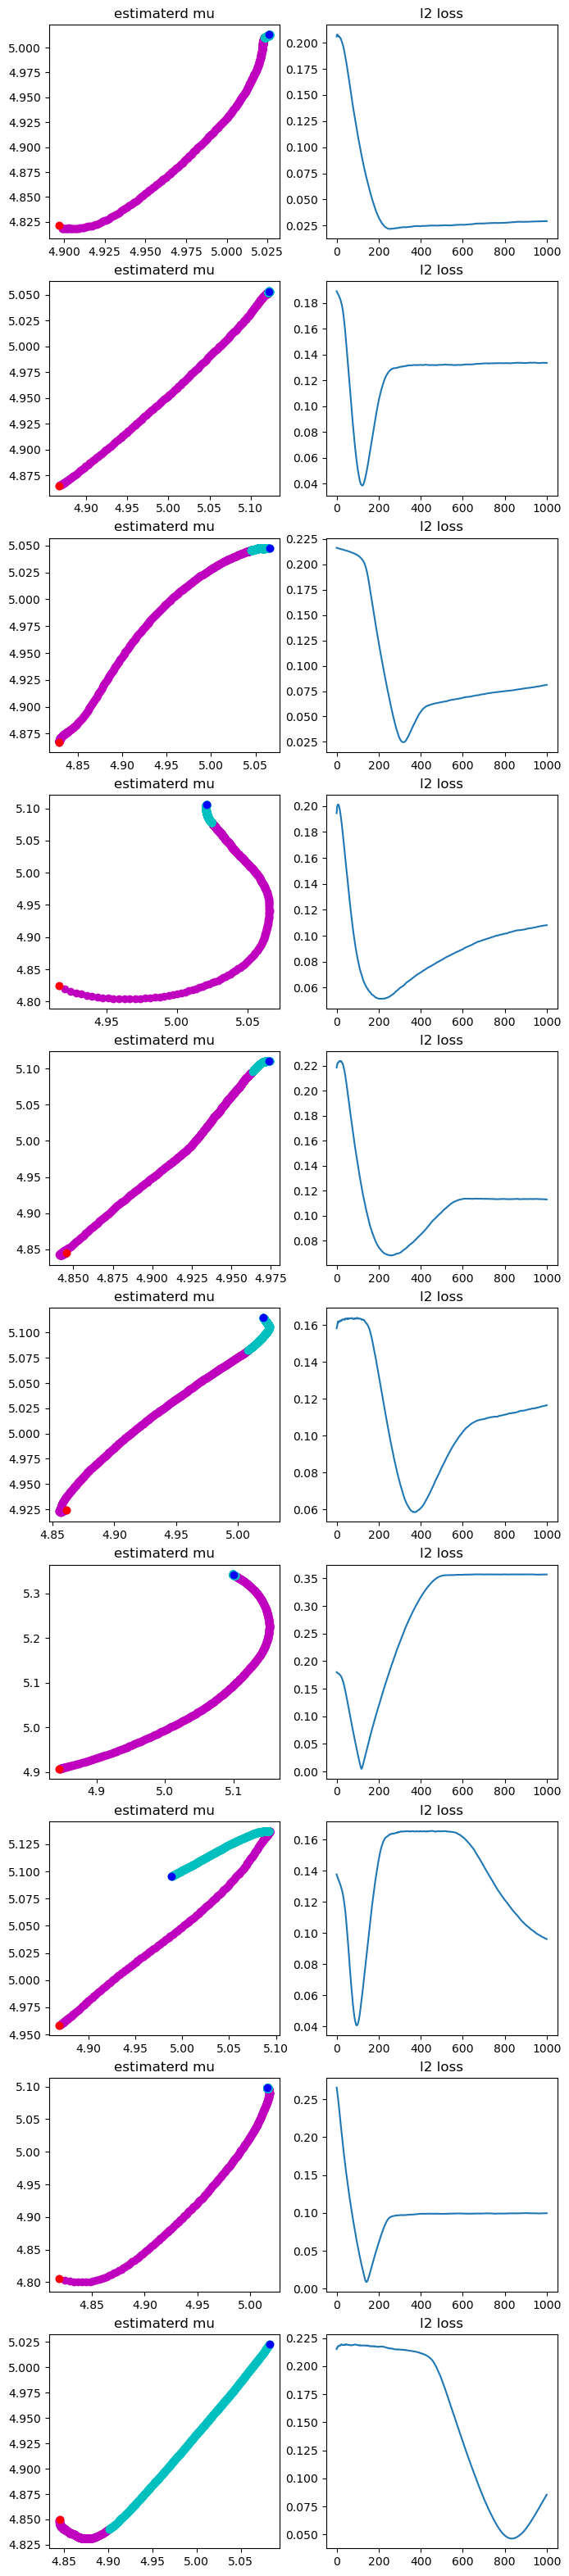

In [41]:
plot_2dim(res)

0.44114500108324495
0.42364199343485676
0.49231718829295984
mean is 0.4523680609370205
sd is   0.029138043878072055
datamean1.6039508840790668
median  0.5378863601241085


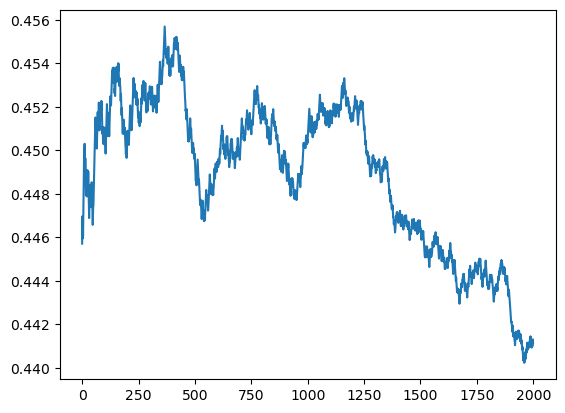

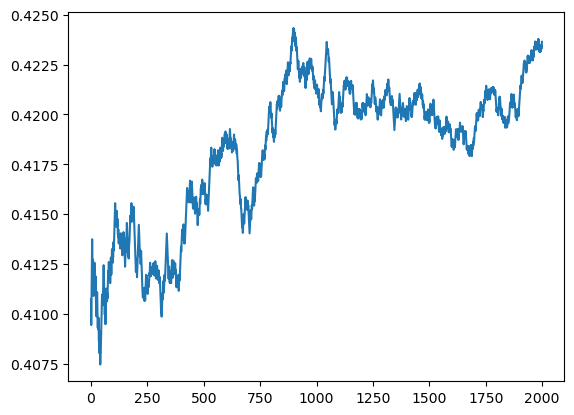

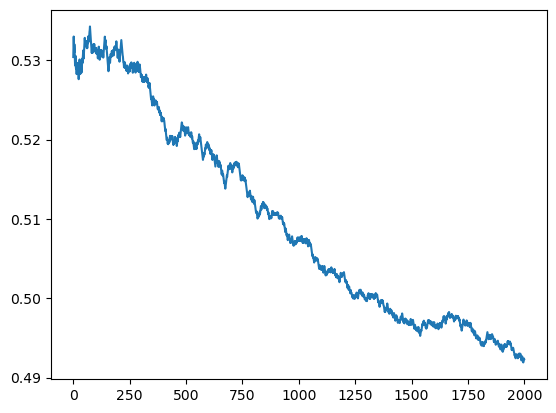

In [20]:
#eps 0.1 n = 100
l2_loss = []
npres = np.array(res)
for i in range(exper_iter):
    loss = np.linalg.norm(par_mu - npres[i], ord=2, axis = 1)
    l2_loss.append(loss[-1])
    plt.subplots()
    plt.plot(loss)
    print(l2_loss[i])
print("mean is " + str(np.mean(l2_loss)))
print("sd is   " + str(np.std(l2_loss)))
print("datamean" + str(np.linalg.norm(par_mu -np.mean(data), ord=2)))
print("median  " + str(np.linalg.norm(par_mu -np.median(data), ord=2)))